## 1. Extract headlines from Finviz

In [1]:
from bs4 import BeautifulSoup
from pprint import pprint
import requests
import pandas as pd
url = "https://finviz.com/quote.ashx?t=GOOGL"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

html_tables =[]
for data in soup:
    data = soup.find(id='news-table')
    html_tables.append(data)

## 2. Format data

In [44]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for news_table in html_tables:
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
#         print(date_scrape)
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        parsed_news.append([date, time, x.a.text])

## 3. NLTK VADER for sentiment analysis

In [9]:
# NLTK VADER for sentiment analysis
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
# nltk.download('stopwords')
vader.lexicon.update(new_words)

## 4. Combine scores with original dataframe

In [45]:
# Use these column names
columns = ['date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news,columns=columns)
# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(news[2]) for news in parsed_news]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = scored_news.join(scores_df)
# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

## 5. Preliminary visualization of scores

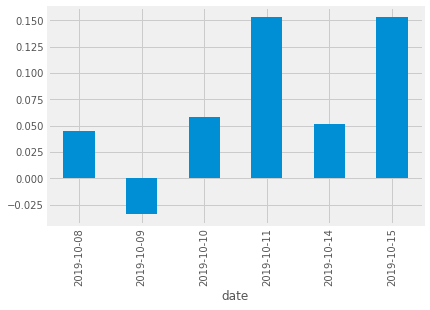

In [34]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date']).mean()
# Unstack the column ticker
mean_c = mean_c.unstack(1)
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c['compound']
# Plot a bar chart with pandas
mean_c.head()
mean_c.plot.bar()

## 6. Remove duplicated headlines

In [22]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = len(scored_news)
# sum(scored_news.duplicated(subset=['headline']))
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset = ['headline'])
# Count number of headlines after dropping duplicates
num_news_after = len(scored_news_clean)
# Print before and after numbers to get an idea of how we did 
print(f"Before we had {num_news_before} headlines, now we have {num_news_after}")
scored_news_clean.head()

Before we had 6700 headlines, now we have 97


,date,time,headline,compound,neg,neu,pos
0,2019-10-15,11:18AM,"Google debuts new Pixelbook Go, Pixel Buds, an...",0.0000,0.0,1.00,0.00
1,2019-10-15,11:00AM,UPDATE 2-Google unveils Pixel 4 phones with ra...,0.0000,0.0,1.00,0.00
2,2019-10-15,10:34AM,Is Salesforce Stock A Buy? Investors Mull Digi...,0.0000,0.0,1.00,0.00
3,2019-10-15,10:34AM,"Google unveils mid-tier Pixelbook Go laptop, w...",0.0000,0.0,1.00,0.00
4,2019-10-15,10:03AM,France to redouble efforts to create EU tech r...,0.2732,0.0,0.84,0.16


## 7. Prepare data for visualization

In [39]:
# Set the index to ticker and date
scored_news_date = scored_news_clean.set_index(['date'])
# Group by mean of compound score of each date
scored_news_date = scored_news_date.groupby('date').mean()
print(scored_news_date['compound'])

date
2019-10-08    0.044723
2019-10-09   -0.034050
2019-10-10    0.061250
2019-10-11    0.164214
2019-10-14    0.051386
2019-10-15    0.141360
Name: compound, dtype: float64


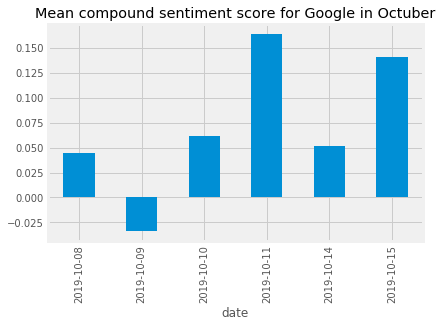

In [40]:
TITLE = "Mean compound sentiment score for Google in Octuber"
scored_news_date['compound'].plot.bar(title=TITLE)

<p>The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

In [ ]:
# random forest classifier

In [ ]:
# google prices over 8 days -> target variable